In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'test-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F399530%2F767109%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T154150Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D988214cdf2fd44ee15396d48a6a89c9b0f4e0e6200966eb00d4d5f3b832a8d0ea1fb0a26531d3ee8ed0e476cf14a4c769c2f86be8aecfab98e29f57178b53042a15962a97d68ed55b0de9cd12a9ad5cd6b60170d2cac68a6f2cc8b64e5b24a22dc247f9ff866f7f1f8c39ce3d9e6960753447259c4c7cdfcc9fc69e13c7e0d8a249c7c93be5a73b44db735c01d7eb0d118fb6c23c27bdcb4c9754029fc00b7c31323d0dda1226537a9449b5d4e4cf8204b2e0078c87f35e026bc78585df4a08677487f3c8b4e19a8ee85cbe4454e1909e7cc4eeb9f5e84f3959f5830107be2125040459191ef26c8afe08deddd8a3f0bd4ba08d0ee4c982c9e67c20e4036c188,fire-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F529007%2F969357%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T154150Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D62e9bce615d9ecb6658e2e4a2230b249be9c153b3802c5ce6f21ac4c9bfc2853504e8571068dea4476bd57dfa63ce4d60cd0640a2f3f8c479446c606328bd554ce5a612bd97383e421b382ca280fc6d0394967fd1d662bb35b931df1d9a5dbd1c95e3b4228e9f59e47115abb1aba2cfd49e85d69f5c162de0c616017f88ba891e6970f94b6ee308f131deeba7422ba6288dfee257ae631aed314a7a95c33a3de9baec50a64cb037dd988fda0752aa776764f64ee4a0701c8e0e007b648f8118aaa4da5bd14e3df198d2e0bcd810493981cf039695321a9b98597646a01bd3753921c1832ffcc3aa4dc0d3c8428c186625b717225d0cb60328800e8caa09658e4,forest-fire-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1265515%2F2287662%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T154150Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6fd8061521ccd418b653e89aea10fe561443d1e4973c940dccb654487a616313ebba83c6e967e66b704cd3c33e81f16b5d70c4c605f24989a79831a44110fd2948a93095f28155962083fb96a507a81de4b318516b95a15829ed82a6878c931b5a4a7e2e8ddc629507fdc8269156b28f08a5b0f1cd65b7287b21f3b37b94148c87d69cf6553ac403792650a16c975055402536c01e1e70d4ece5a7b69ae2c9a095b5c60654002588006d1c901720d73dbddd7017d1c14d5fb3b03342f4ef9b06aabb082d6b3c6f64b67dd451f4daa67bc6f11ae010c5aeb739e9b1d01d0753396a38bc160aadddae970fe0c8e258930a449d4af312505638edc9d06a611f1aaa,fire-and-smoke-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1402026%2F2326401%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T154150Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9b3215581fe67fb5bc6606f97c3633ca84276b5e805fb0a3706438280d9b67fe440fa43a5619db8f313a49f13a271c811b9e2b8c9e053a60a1a5af62bc26f08ccc2370129374655b6da70805fd1d7a6a6f342ae7b64239add769cd0a9a0f7dbba90bfca1ac07855cb061d635acf5e208efd53e0dfead2d4e8d1b26f9100b978f8a1b31ce71ba6912b302b2738b4007980c48a3ffabc30f985bb53ec6a753f4b7e3683575d4722d228f7d07316d520ff95c0d7ebe467b85dfddcc783d3dedce2b1f1bd6b798f775cf998efc68264d1d8580afce5c8b7bd7e468eb0661c1c47afb62385e6f36c2f92b6c6491ee1236b3ed50852f80e2fad99c61e4597dddded8a6,forest-fire-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1770494%2F2890158%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T154150Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8b778d7ff77faaa9fd48e88bc3ec9bef9c0d248132db23ec9abfaae9916ba1263aff43c24795759b68b62feb5b96a4f7a2f98b8189ea4d073a4bad93d9b49315791604120b1d9790786591387aa7cb2c79f7656227ebfc5483c9c4ec0a92f00ee16d2ca5cca52f6eb52fe97f499d5ab07689b15242fe792f2faf59775980b75da7ebfbdbf7a0f8d7e09617c3300059d9ab713c3f1cff85f3641c4d6bf42834f6ad759bdd57f7e81ff580ac416a03aaad9de54aa9e2838e53798e7af0b019c91e74246b63607ad1b4f967693d27f4ecf3aea3cbf40cb19f1ca9953f4a756c9385892f7cc7be6f77d037c6448d996eedd53e33bb36787188b6576e540437204787'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 138152460 bytes downloaded
Downloaded and uncompressed: test-dataset
[==================================================] 406135295 bytes downloaded
Downloaded and uncompressed: fire-dataset
[==================================================] 1260516303 bytes downloaded
Downloaded and uncompressed: forest-fire-image-dataset
[==================================================] 88550583 bytes downloaded
Downloaded and uncompressed: fire-and-smoke-dataset
[==================================================] 403717450 bytes downloaded
Downloaded and uncompressed: forest-fire-images
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [ ]:
import pathlib
fire_image_path_array = ["../input/forest-fire-images/Data/Train_Data/Fire","/kaggle/input/forest-fire-image-dataset/FOREST_FIRE_DATASET/FIRE","/kaggle/input/fire-dataset/fire_dataset/fire_images","/kaggle/input/forest-fire-images/Data/Test_Data/Fire","/kaggle/input/test-dataset/Fire-Detection/1","/kaggle/input/fire-and-smoke-dataset/Datacluster Fire and Smoke Sample"]
non_fire_path_array = ["../input/forest-fire-images/Data/Train_Data/Non_Fire","/kaggle/input/forest-fire-image-dataset/FOREST_FIRE_DATASET/NON_FIRE","/kaggle/input/fire-dataset/fire_dataset/non_fire_images","/kaggle/input/forest-fire-images/Data/Test_Data/Non_Fire","/kaggle/input/test-dataset/Fire-Detection/0"]
fire_image_path = pathlib.Path(fire_image_path_array[0])
non_fire_path = pathlib.Path(non_fire_path_array[0])
for path in fire_image_path_array[1:]:
    fire_image_path.joinpath(path)

for path in non_fire_path_array[1:]:
    non_fire_path.joinpath(path)

In [ ]:
import glob
from itertools import chain

train_data_images = {
    "Fire":list(chain(fire_image_path.glob('*.jpg'), fire_image_path.glob('*.png'))),
    "NonFire":list(chain(non_fire_path.glob('*.jpg'), non_fire_path.glob('*.png')))
}
train_labels = {
    "Fire":0,"NonFire":1
}

In [ ]:
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

In [ ]:
X, y = [], []
for label, images in train_data_images.items():
    for image in images:
        img = cv2.imread(str(image)) # Reading the image
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (180, 180))
            X.append(img)
            y.append(train_labels[label])

In [ ]:
import numpy
X_samp = numpy.array(X)
y_samp = numpy.array(y)

In [ ]:
X_samp = (X_samp/255)

In [ ]:
X_samp.shape

(4609, 180, 180, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size=0.2)

In [ ]:
data_argumentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomContrast(0.2),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

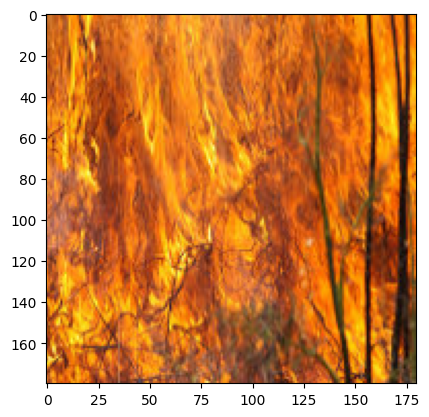

In [ ]:
plt.imshow(X_train[0])

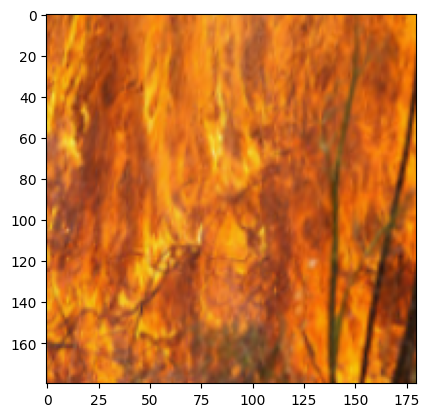

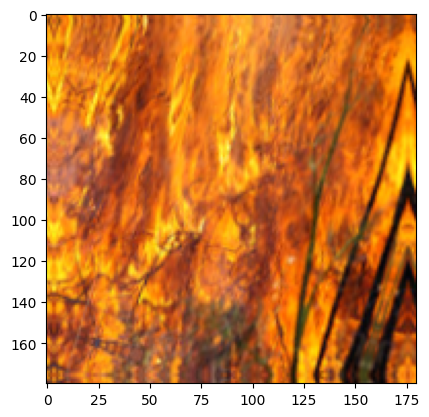

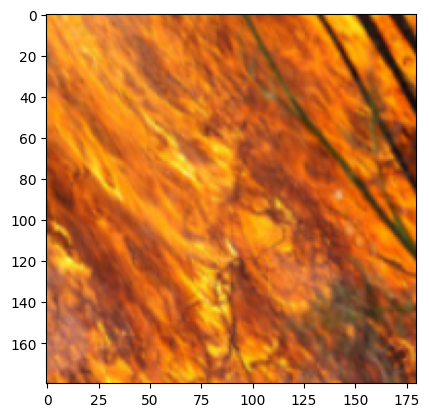

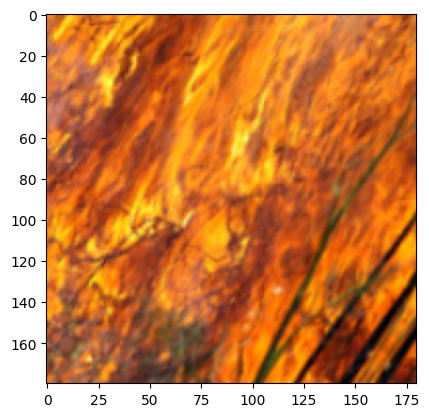

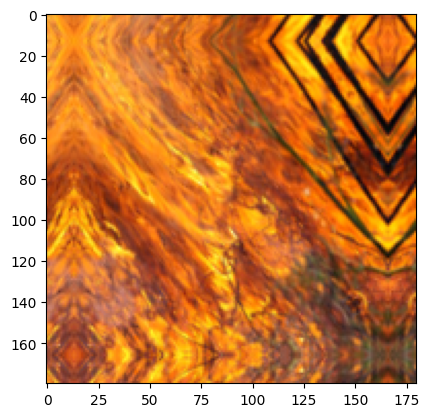

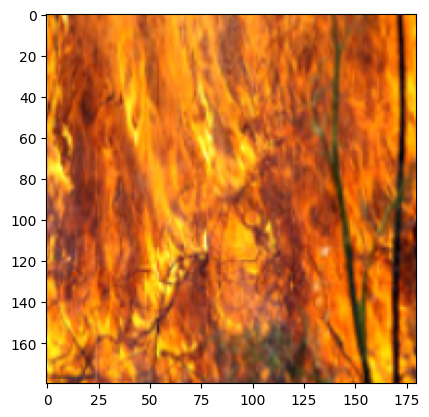

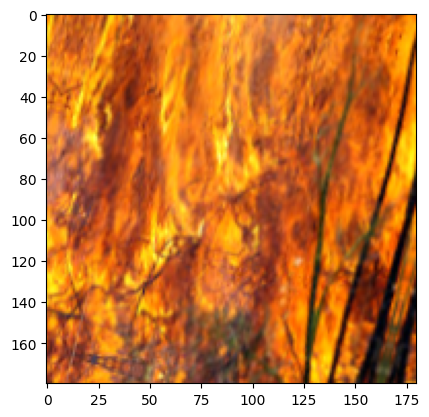

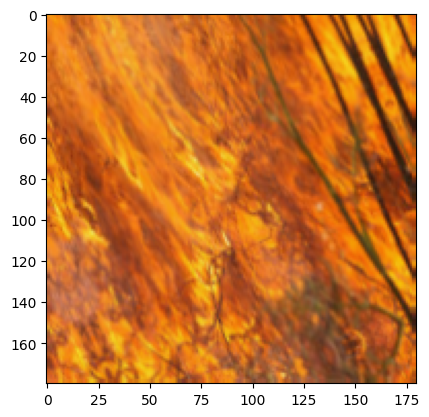

In [ ]:
for i in range(8):
    plt.imshow(data_argumentation(X_train[0]))
    plt.show()

In [ ]:
model = keras.Sequential([
    data_argumentation,
    keras.layers.Conv2D(64, (3,3), padding='same', activation="relu", input_shape=(180, 180, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, (3,3), padding='same', activation="softmax"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16, (3,3), padding='same', activation="softmax"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="sigmoid"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
116/116 [==============================] - 13s 49ms/step - loss: 0.5775 - accuracy: 0.6656 - val_loss: 0.3787 - val_accuracy: 0.8557
Epoch 2/20
116/116 [==============================] - 4s 33ms/step - loss: 0.3536 - accuracy: 0.8649 - val_loss: 0.3014 - val_accuracy: 0.8980
Epoch 3/20
116/116 [==============================] - 4s 34ms/step - loss: 0.3024 - accuracy: 0.8899 - val_loss: 0.3334 - val_accuracy: 0.8677
Epoch 4/20
116/116 [==============================] - 4s 33ms/step - loss: 0.2939 - accuracy: 0.8918 - val_loss: 0.2606 - val_accuracy: 0.9132
Epoch 5/20
116/116 [==============================] - 4s 34ms/step - loss: 0.2749 - accuracy: 0.8961 - val_loss: 0.2695 - val_accuracy: 0.9121
Epoch 6/20
116/116 [==============================] - 4s 33ms/step - loss: 0.2645 - accuracy: 0.9032 - val_loss: 0.2336 - val_accuracy: 0.9208
Epoch 7/20
116/116 [==============================] - 4s 33ms/step - loss: 0.2485 - accuracy: 0.9113 - val_loss: 0.2251 - val_accuracy: 0.931

In [ ]:
## BEGIN_SOLUTION
from tensorflow.keras.applications import MobileNetV2, ResNet50, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

base_model_densenet = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
x = base_model_densenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
predictions_densenet = keras.layers.Dense(1, activation='sigmoid')(x)
model_densenet = keras.Model(inputs=base_model_densenet.input, outputs=predictions_densenet)

# ResNet50 Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions_resnet = Dense(1, activation='sigmoid')(x)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)

# Xception Model
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
x = base_model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions_xception = Dense(1, activation='sigmoid')(x)
model_xception = Model(inputs=base_model_xception.input, outputs=predictions_xception)

# Compile the models
model_densenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the models
history_densenet=model_densenet.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
history_resnet=model_resnet.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))
history_xception=model_xception.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Predictions
y_pred_mobilenet = model_densenet.predict(X_test)
y_pred_resnet = model_resnet.predict(X_test)
y_pred_xception = model_xception.predict(X_test)

# Ensemble Model (Majority Voting)
ensemble_predictions = (y_pred_mobilenet + y_pred_resnet + y_pred_xception) / 3
ensemble_predictions = (ensemble_predictions > 0.5).astype(int)

# Evaluate Individual Models
print("\nDenseNet:")
print("Accuracy:", accuracy_score(y_test, (y_pred_mobilenet > 0.5).astype(int)))
print("F1 Score:", f1_score(y_test, (y_pred_mobilenet > 0.5).astype(int)))
print("Recall:", recall_score(y_test, (y_pred_mobilenet > 0.5).astype(int)))

print("\nResNet50:")
print("Accuracy:", accuracy_score(y_test, (y_pred_resnet > 0.5).astype(int)))
print("F1 Score:", f1_score(y_test, (y_pred_resnet > 0.5).astype(int)))
print("Recall:", recall_score(y_test, (y_pred_resnet > 0.5).astype(int)))

print("\nXception:")
print("Accuracy:", accuracy_score(y_test, (y_pred_xception > 0.5).astype(int)))
print("F1 Score:", f1_score(y_test, (y_pred_xception > 0.5).astype(int)))

 # Xception:")
print("Accuracy:", accuracy_score(y_test, (y_pred_xception > 0.5).astype(int)))
print("F1 Score:", f1_score(y_test, (y_pred_xception > 0.5).astype(int)))
print("Recall:", recall_score(y_test, (y_pred_xception > 0.5).astype(int)))

# Evaluate Ensemble Model
print("\nEnsemble Model (Majority Voting):")
print("Accuracy:", accuracy_score(y_test, ensemble_predictions))
print("F1 Score:", f1_score(y_test, ensemble_predictions))
print("Recall:", recall_score(y_test, ensemble_predictions))
## END_SOLUTION

83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/100
116/116 [==============================] - 92s 212ms/step - loss: 0.1690 - accuracy: 0.9390 - val_loss: 0.5332 - val_accuracy: 0.8905
Epoch 2/100
116/116 [==============================] - 16s 136ms/step - loss: 0.1022 - accuracy: 0.9656 - val_loss: 0.2702 - val_accuracy: 0.9100
Epoch 3/100
116/116 [==============================] - 16s 136ms/step - loss: 0.0816 - accuracy: 0.9723 - val_loss: 0.4731 - val_accuracy: 0.9176
Epoch 4/100
116/116 [==============================] - 16s 137ms/step - loss: 0.0702 - accuracy: 0.9745 - val_loss: 0.0935 - val_accuracy: 0.9696
Epoch 5/100
116/116 [==============================] - 16s 136ms/step - loss: 0.0709 - accuracy: 0.9737 - val_loss: 0.0910 - val_accuracy: 0.9729
Epoch 6/100
116/116 [==============================] - 16s 136ms/step - loss: 0.0610 - accuracy: 0.9805 - val_loss: 0.1103 - val_accuracy: 0.9675
Epoch 7/100
116/116 [==============================] - 16s 

In [ ]:
from sklearn.metrics import classification_report

# Assuming y_pred_* variables hold the predicted probabilities
y_pred_mobilenet_binary = (y_pred_mobilenet > 0.5).astype(int)
y_pred_resnet_binary = (y_pred_resnet > 0.5).astype(int)
y_pred_xception_binary = (y_pred_xception > 0.5).astype(int)

print("\nDenseNet Classification Report:")
print(classification_report(y_test, y_pred_mobilenet_binary))

print("\nResNet50 Classification Report:")
print(classification_report(y_test, y_pred_resnet_binary))

print("\nXception Classification Report:")
print(classification_report(y_test, y_pred_xception_binary))
from sklearn.metrics import classification_report

# Assuming ensemble_predictions holds the predicted labels from the ensemble model
print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, ensemble_predictions))


DenseNet Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       411
           1       0.99      0.98      0.98       511

    accuracy                           0.98       922
   macro avg       0.98      0.98      0.98       922
weighted avg       0.98      0.98      0.98       922


ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       411
           1       0.97      0.99      0.98       511

    accuracy                           0.98       922
   macro avg       0.98      0.98      0.98       922
weighted avg       0.98      0.98      0.98       922


Xception Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       411
           1       0.98      0.97      0.98       511

    accuracy                           0.98       922
   macro avg       0.98      

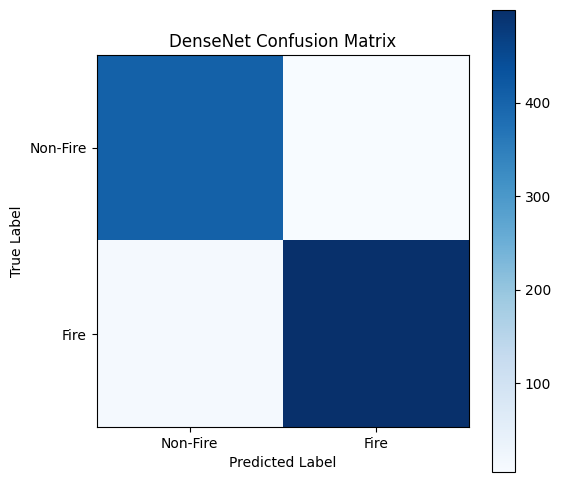

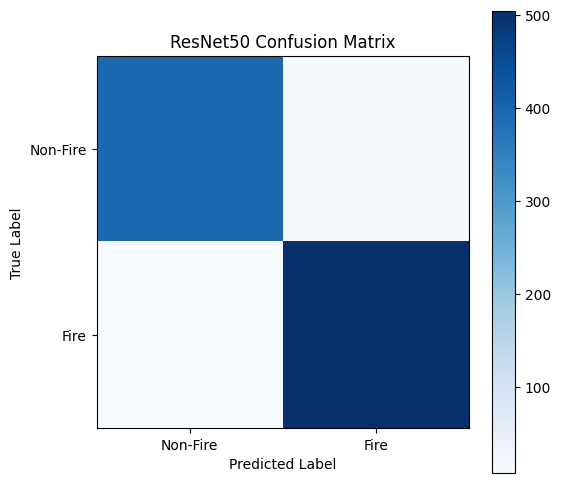

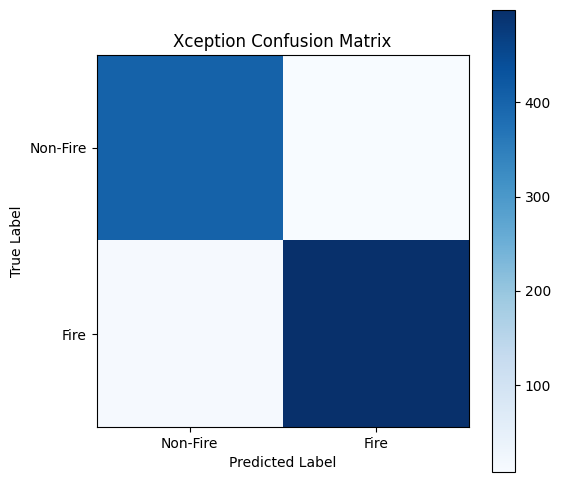

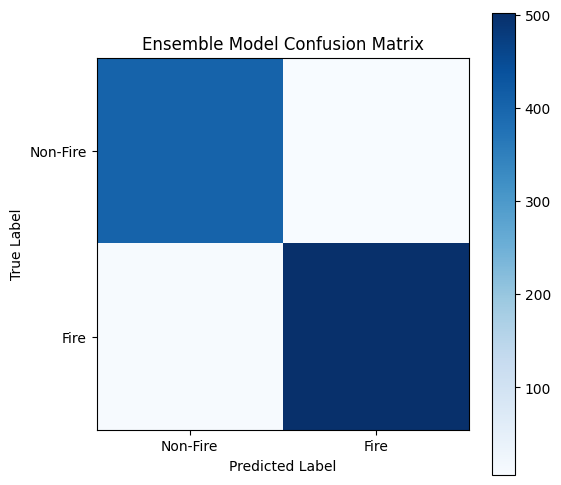

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming y_pred_* variables hold the predicted probabilities
y_pred_densenet_binary = (y_pred_mobilenet > 0.5).astype(int)
y_pred_resnet_binary = (y_pred_resnet > 0.5).astype(int)
y_pred_xception_binary = (y_pred_xception > 0.5).astype(int)

# DenseNet Confusion Matrix
cm_densenet = confusion_matrix(y_test, y_pred_mobilenet_binary)
plt.figure(figsize=(6, 6))
plt.imshow(cm_densenet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("DenseNet Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ResNet50 Confusion Matrix
cm_resnet = confusion_matrix(y_test, y_pred_resnet_binary)
plt.figure(figsize=(6, 6))
plt.imshow(cm_resnet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("ResNet50 Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Xception Confusion Matrix
cm_xception = confusion_matrix(y_test, y_pred_xception_binary)
plt.figure(figsize=(6, 6))
plt.imshow(cm_xception, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Xception Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Ensemble Model Confusion Matrix
cm_ensemble = confusion_matrix(y_test, ensemble_predictions)
plt.figure(figsize=(6, 6))
plt.imshow(cm_ensemble, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Ensemble Model Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

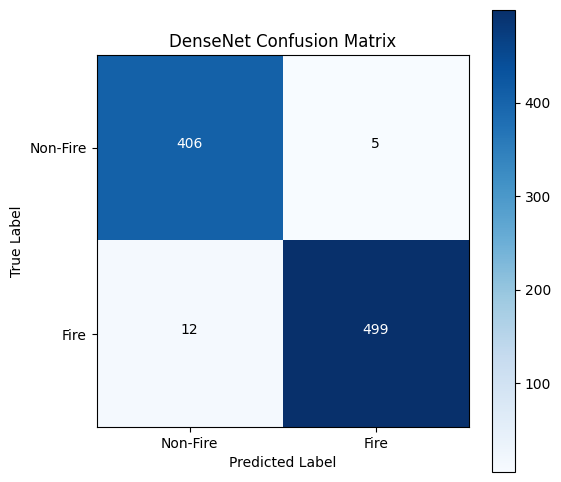

In [ ]:
from sklearn.metrics import confusion_matrix

# ... (previous code to calculate confusion matrices)

# DenseNet Confusion Matrix
cm_densenet = confusion_matrix(y_test, y_pred_mobilenet_binary)
plt.figure(figsize=(6, 6))
plt.imshow(cm_densenet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("DenseNet Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
thresh = cm_densenet.max() / 2.
for i in range(cm_densenet.shape[0]):
    for j in range(cm_densenet.shape[1]):
        plt.text(j, i, format(cm_densenet[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_densenet[i, j] > thresh else "black")

plt.show()

# Repeat the same process for ResNet50, Xception, and Ensemble Model confusion matrices
# ...

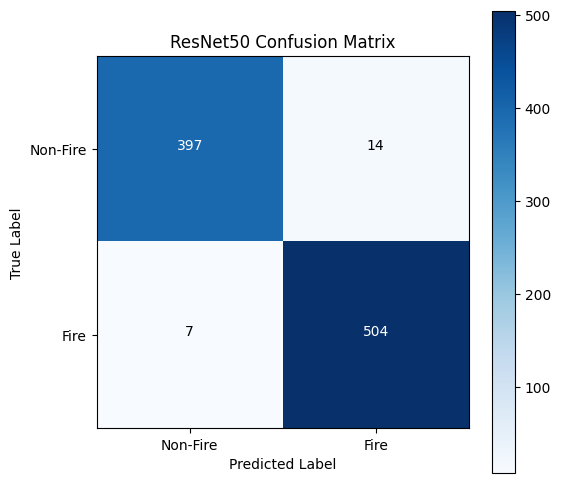

In [ ]:
cm_resnet = confusion_matrix(y_test, y_pred_resnet_binary)
plt.figure(figsize=(6, 6))
plt.imshow(cm_resnet, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("ResNet50 Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
thresh = cm_resnet.max() / 2.
for i in range(cm_resnet.shape[0]):
    for j in range(cm_resnet.shape[1]):
        plt.text(j, i, format(cm_resnet[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_resnet[i, j] > thresh else "black")

plt.show()

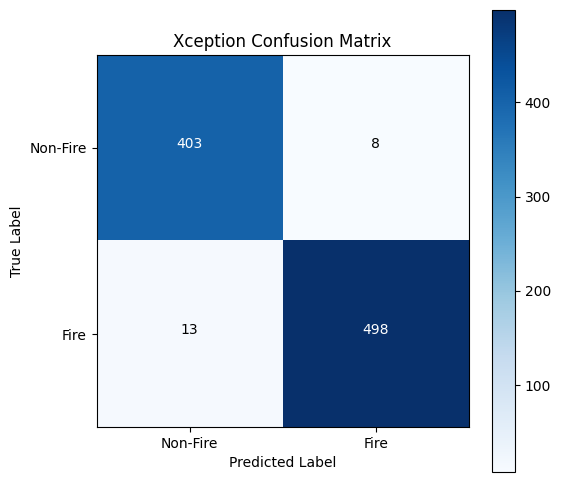

In [ ]:
cm_xception = confusion_matrix(y_test, y_pred_xception_binary)
plt.figure(figsize=(6, 6))
plt.imshow(cm_xception, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Xception Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
thresh = cm_xception.max() / 2.
for i in range(cm_xception.shape[0]):
    for j in range(cm_xception.shape[1]):
        plt.text(j, i, format(cm_xception[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_xception[i, j] > thresh else "black")

plt.show()

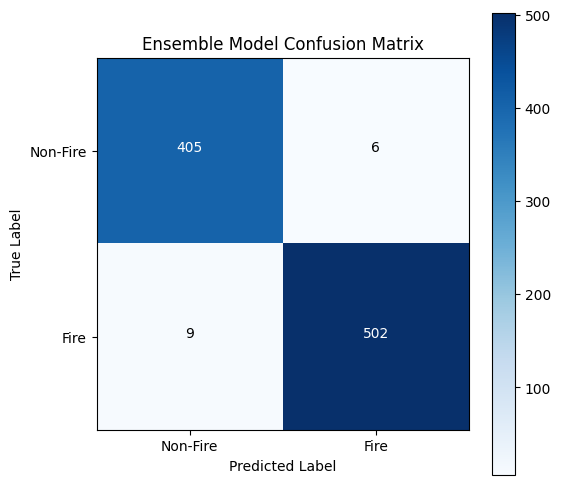

In [ ]:
cm_ensemble = confusion_matrix(y_test, ensemble_predictions)
plt.figure(figsize=(6, 6))
plt.imshow(cm_ensemble, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Ensemble Model Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Fire', 'Fire'])
plt.yticks([0, 1], ['Non-Fire', 'Fire'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
thresh = cm_ensemble.max() / 2.
for i in range(cm_ensemble.shape[0]):
    for j in range(cm_ensemble.shape[1]):
        plt.text(j, i, format(cm_ensemble[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_ensemble[i, j] > thresh else "black")

plt.show()

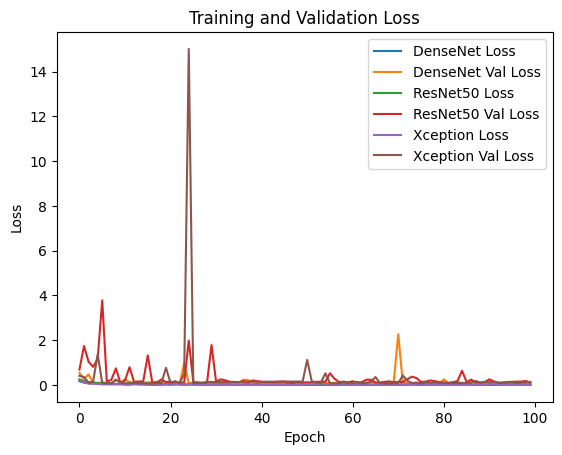

In [ ]:
plt.plot(history_densenet.history['loss'], label='DenseNet Loss')
plt.plot(history_densenet.history['val_loss'], label='DenseNet Val Loss')
plt.plot(history_resnet.history['loss'], label='ResNet50 Loss')
plt.plot(history_resnet.history['val_loss'], label='ResNet50 Val Loss')
plt.plot(history_xception.history['loss'], label='Xception Loss')
plt.plot(history_xception.history['val_loss'], label='Xception Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

--2024-06-25 18:04:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-25 18:04:37 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



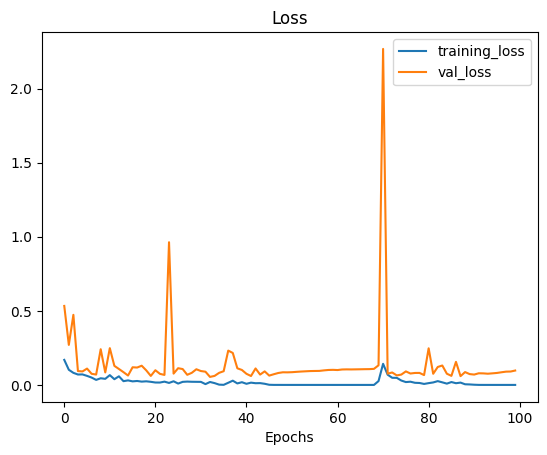

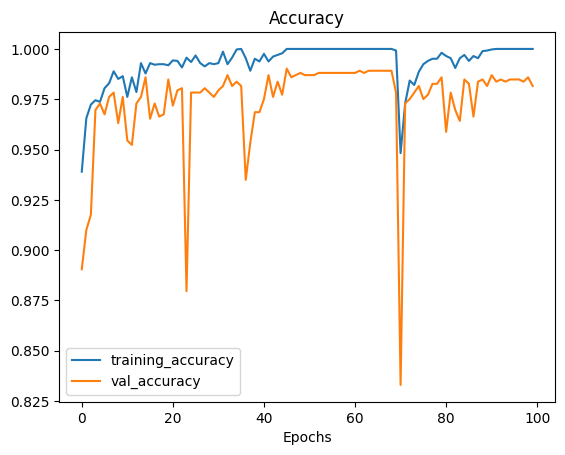

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

plot_loss_curves(history_densenet)

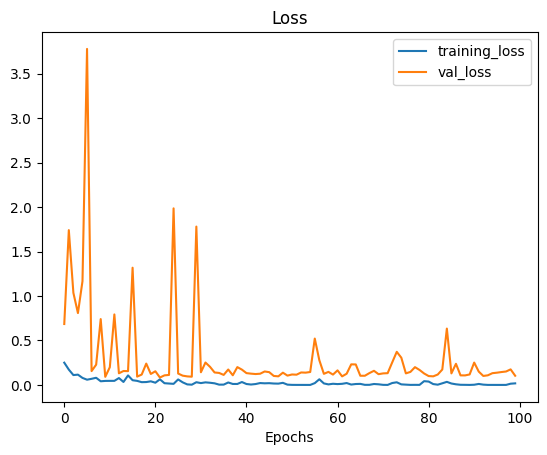

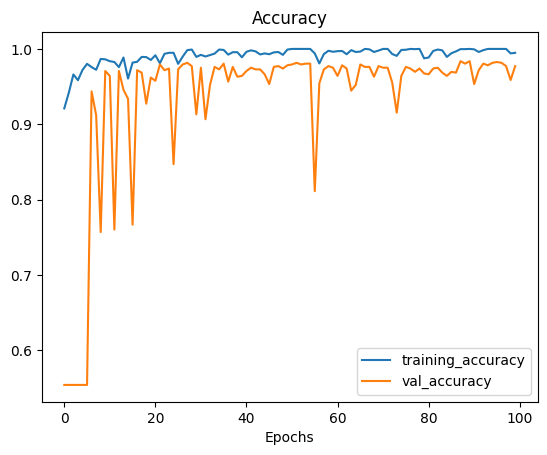

In [ ]:

plot_loss_curves(history_resnet)


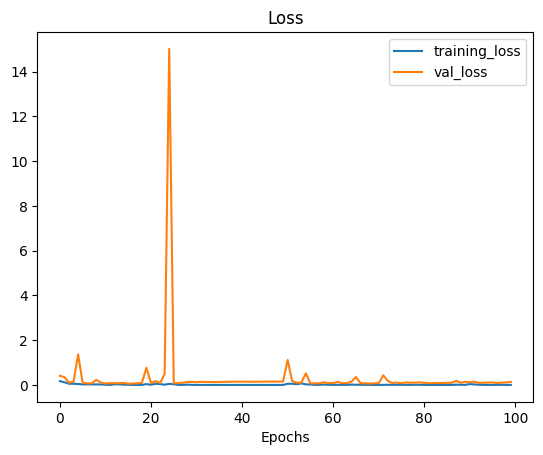

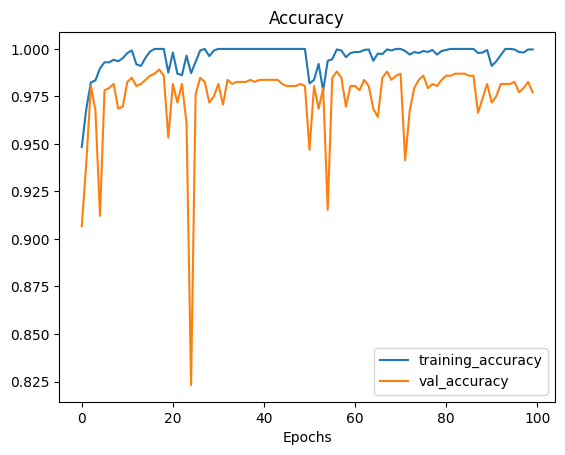

In [ ]:
plot_loss_curves(history_xception)
